# Neural network learning from scratch (Math + Numpy)

This notebook is a part of the series __From Scratch__, where i try to code machine learning algorithms from scratch (just numpy and math)

This is a major milestone during my self-taught machine learning journey. Understanding the backpropagation and calculus in it is quite an experience. That said, this is really the simplest implementation :p.

In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization
from tensorflow.keras.activations import linear, relu, sigmoid, softmax
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.datasets import mnist
import tensorflow as tf
from tqdm import tqdm

### Objective: Determine a tumor's malignancy given its texture_mean and radius_mean

#### The dataset

In [2]:
df = pd.read_csv("bdiag.csv")[["diagnosis", "texture_mean", "radius_mean"]]
df["diagnosis"] = df["diagnosis"].replace({"M":1, "B":0})
df

,diagnosis,texture_mean,radius_mean
0,1,10.38,17.99
1,1,17.77,20.57
2,1,21.25,19.69
3,1,20.38,11.42
4,1,14.34,20.29
...,...,...,...
564,1,22.39,21.56
565,1,28.25,20.13
566,1,28.08,16.60
567,1,29.33,20.60


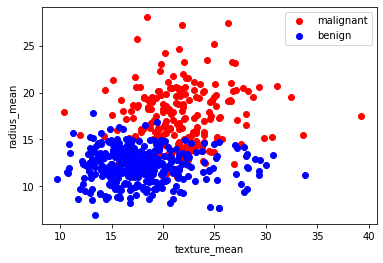

In [233]:
fig, ax = plt.subplots()

mal = df[df["diagnosis"]==1]
ben = df[df["diagnosis"]==0]

ax.scatter(mal["texture_mean"], mal["radius_mean"], label="malignant", c="r")
ax.scatter(ben["texture_mean"], ben["radius_mean"], label="benign", c="b")
ax.set_xlabel("texture_mean")
ax.set_ylabel("radius_mean")
ax.legend()

plt.show()


### Train-test split

In [3]:
X = df[["texture_mean", "radius_mean"]].values
y = df["diagnosis"].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [4]:
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))

X_train: (455, 2)
Y_train: (455, 1)
X_test:  (114, 2)
Y_test:  (114, 1)


### Baseline model

predict only based on the mean of radius_mean

In [249]:
rad_mean = X_test
diag = y_test
mean = rad_mean.mean()
pred = np.where(rad_mean>mean, 1, 0)
(pred==diag).mean()

0.8070175438596491

### Feature normalization

In [5]:
norm = Normalization(axis=1)
norm.adapt(X_train)

In [6]:
X_train = np.array(norm(X_train))  # converts back to numpy because tensor is slower
X_test = np.array(norm(X_test))

### The Model overview

![alt text](model_nn_scratch.jpg "test")

## Doing it the "easy" way (using library)

In [250]:
model = Sequential([
    
    Dense(units=2, activation=relu),
    Dense(units=1, activation=linear)
])

model.compile(loss=BinaryCrossentropy(from_logits=True),  # to avoid numerical instability
              optimizer=Adam(learning_rate=0.01),
              metrics="accuracy"
             )
model.fit(X_train, y_train, epochs=80)

Epoch 1/80
15/15 [==============================] - 10s 8ms/step - loss: 0.7970 - accuracy: 0.5055
Epoch 2/80
15/15 [==============================] - 0s 4ms/step - loss: 0.7055 - accuracy: 0.5824
Epoch 3/80
15/15 [==============================] - 0s 12ms/step - loss: 0.6626 - accuracy: 0.6066
Epoch 4/80
15/15 [==============================] - 0s 5ms/step - loss: 0.6311 - accuracy: 0.6176
Epoch 5/80
15/15 [==============================] - 0s 3ms/step - loss: 0.5961 - accuracy: 0.6154
Epoch 6/80
15/15 [==============================] - 0s 3ms/step - loss: 0.5547 - accuracy: 0.6176
Epoch 7/80
15/15 [==============================] - 0s 5ms/step - loss: 0.5097 - accuracy: 0.6242
Epoch 8/80
15/15 [==============================] - 0s 5ms/step - loss: 0.4647 - accuracy: 0.6352
Epoch 9/80
15/15 [==============================] - 0s 5ms/step - loss: 0.4240 - accuracy: 0.6901
Epoch 10/80
15/15 [==============================] - 0s 7ms/step - loss: 0.3872 - accuracy: 0.7692
Epoch 11/80
15/15

### Evaluation

In [251]:
model.evaluate(X_test, y_test, batch_size=1)

114/114 [==============================] - 1s 2ms/step - loss: 0.2026 - accuracy: 0.9123


[0.20262475311756134, 0.9122806787490845]

# Doing it the hard way (scratch)

### The math

2 features --> 1 hidden layer (2 neuron relu) --> 1 output layer (1 neuron sigmoid)

#### Forward propagation:

$$z_{1}^{[1]} = w_{1}^{[1]}x_{1} + w_{2}^{[1]}x_{2} + b_{1}^{[1]} $$ <br>
$$z_{2}^{[1]} = w_{3}^{[1]}x_{1} + w_{4}^{[1]}x_{2} + b_{2}^{[1]} $$ <br>
$$a_{1}^{[1]} = \text{relu}(z_{1}^{[1]})$$ <br>
$$a_{2}^{[1]} = \text{relu}(z_{2}^{[1]})$$ <br>
$$z^{[2]} = w_{1}^{[2]}x_{1} + w_{2}^{[2]}x_{2} + b^{[2]} $$ <br>
$$a^{[2]} = \frac{1}{1 + e^{-z^{[2]}}}$$ <br>

#### cost & loss function: <br>
$$\text{cross entropy cost}(\hat{a}^{[2]}, \hat{y}) = -\frac{1}{n}\sum_{i=1}^{n}\sum_{j=1}^{m}y_{ij}\text{log}(a^{[2]}[ij])$$ <br>
$$\text{binary cross entropy cost}(\hat{a}^{[2]}, \hat{y}) = -\frac{1}{n}\sum_{i=1}^{n}y_{i}\text{log}(a^{[2]}[i]) + (1-y_{i})\text{log}(1-a^{[2]}[i])$$ <br>

#####  Derivative of cost function w.r.t parameters
$$\frac{\partial ( \text{binary cross entropy cost}(\vec{a}^{[2]}, \vec{y}))}{\partial \vec{w}} = \frac{1}{n}(\frac {\partial (\text{binary cross entropy loss}(a^{[2]}, \hat{y}))_{1}}{\partial \vec{w}} + \frac {\partial (\text{binary cross entropy loss}(a^{[2]}, \hat{y}))_{2}}{\partial \vec{w}}+ ...+ \frac {\partial (\text{binary cross entropy loss}(a^{[2]}, \hat{y}))_{n}}{\partial \vec{w}})\space \text{for n=number of examples}$$<br>

$$\text{binary cross entropy loss}(a^{[2]}, \hat{y}) = -(y_{i}\text{log}(a^{[2]}) + (1-y_{i})\text{log}(1-a^{[2]}))$$

- The point of backpropagation is to determine the gradient of cost function wrt to each parameter $w$
- Intuitively speaking, the gradient of cost function wrt to parameter $w$ is the average of all the gradient of loss function wrt to parameter $w_{1}, w_{2},..., w_{n}$ where $n=$number of examples.
- Backpropagation involves the derivation of loss function wrt to each parameters, then averaging them later for gradient descent

#### Backward propagation:

##### output layer
$\frac{\partial \text{cost}(a^{[2]})}{\partial z^{[2]}}=\frac{\partial a^{[2]}}{\partial z^{[2]}}\times\frac{\partial\text{cost}(a^{[2]})}{\partial a^{[2]}} = (1-a^{[2]})\times \frac{a^{[2]}-y}{a^{[2]}(1-a^{[2]})} = a^{[2]} - y$


$$\frac{\partial\text{cost}(a^{[2]})}{\partial w_{1}^{[2]}} = \frac{\partial z^{[2]}}{\partial w_{1}^{[2]}}\times\frac{\partial \text{cost}(a^{[2]})}{\partial z^{[2]}} = a_{1}^{[1]}\times (a^{[2]} - y)$$

$$\frac{\partial\text{cost}(a^{[2]})}{\partial w_{2}^{[2]}} = \frac{\partial z^{[2]}}{\partial w_{2}^{[2]}}\times\frac{\partial \text{cost}(a^{[2]})}{\partial z^{[2]}} = a_{2}^{[1]}\times (a^{[2]} - y)$$

$$\frac{\partial\text{cost}(a^{[2]})}{\partial b^{[2]}} = \frac{\partial z^{[2]}}{\partial b^{[2]}}\times\frac{\partial \text{cost}(a^{[2]})}{\partial z^{[2]}} = a^{[2]} - y$$


##### hidden layer
$\frac{\partial \text{cost}(a^{[2]})}{\partial z_{1}^{[1]}}=\frac{\partial a_{1}^{[1]}}{\partial z_{1}^{[1]}}\times\frac{\partial z^{[2]}}{\partial a_{1}^{[1]}}\times\frac{\partial \text{cost}(a^{[2]})}{\partial z^{[2]}} = \text{relu'}(z_1^{[1]}) \times w_1^{[2]}\times (a^{[2]} - y)$ <br>

$$\frac{\partial\text{cost}(a^{[2]})}{\partial w_{1}^{[1]}} = \frac{\partial z_{1}^{[1]}}{\partial w_{1}^{[1]}}\times \frac{\partial \text{cost}(a^{[2]})}{\partial z_{1}^{[1]}} = x_1\times \text{relu'}(z_1^{[1]}) \times w_1^{[2]}\times (a^{[2]} - y)$$
$$\frac{\partial\text{cost}(a^{[2]})}{\partial w_{2}^{[1]}} = \frac{\partial z_{1}^{[1]}}{\partial w_{2}^{[1]}}\times \frac{\partial \text{cost}(a^{[2]})}{\partial z_{1}^{[1]}} = x_2\times \text{relu'}(z_1^{[1]}) \times w_1^{[2]}\times (a^{[2]} - y)$$ 
$$\frac{\partial\text{cost}(a^{[2]})}{\partial b_{1}^{[1]}} = \frac{\partial z_{1}^{[1]}}{\partial b_{1}^{[1]}}\times \frac{\partial \text{cost}(a^{[2]})}{\partial z_{1}^{[1]}} = \text{relu'}(z_1^{[1]}) \times w_1^{[2]}\times (a^{[2]} - y)$$ 
<br>

$\frac{\partial \text{cost}(a^{[2]})}{\partial z_{2}^{[1]}}=\frac{\partial a_{1}^{[1]}}{\partial z_{2}^{[1]}}\times\frac{\partial z^{[2]}}{\partial a_{1}^{[1]}}\times\frac{\partial \text{cost}(a^{[2]})}{\partial z^{[2]}} = \text{relu'}(z_2^{[1]}) \times w_2^{[2]}\times (a^{[2]} - y)$ <br>

$$\frac{\partial\text{cost}(a^{[2]})}{\partial w_{3}^{[1]}} = \frac{\partial z_{2}^{[1]}}{\partial w_{3}^{[1]}}\times \frac{\partial \text{cost}(a^{[2]})}{\partial z_{1}^{[1]}} = x_1\times \text{relu'}(z_2^{[1]}) \times w_2^{[2]}\times (a^{[2]} - y)$$
$$\frac{\partial\text{cost}(a^{[2]})}{\partial w_{4}^{[1]}} = \frac{\partial z_{1}^{[1]}}{\partial w_{4}^{[1]}}\times \frac{\partial \text{cost}(a^{[2]})}{\partial z_{1}^{[1]}} = x_2\times \text{relu'}(z_1^{[1]}) \times w_1^{[2]}\times (a^{[2]} - y)$$ 
$$\frac{\partial\text{cost}(a^{[2]})}{\partial b_{2}^{[1]}} = \frac{\partial z_{1}^{[1]}}{\partial b_{2}^{[1]}}\times \frac{\partial \text{cost}(a^{[2]})}{\partial z_{1}^{[1]}} = \text{relu'}(z_1^{[1]}) \times w_1^{[2]}\times (a^{[2]} - y)$$ 
<br>

### No vectorization (just for loop), vanilla gradient descent, and non-modular implementation

This implementation is tailored for learning, hence not for production usage. It is meant to be explicit and not use any vectorization. It is also non-modular, as it can only be of the specified architecture and parameters.

In [208]:
class NeuralNetwork():
    
    def initialize(self):
        self.w11, self.w12, self.w13, self.w14, self.w21, self.w22, self.b11, self.b12, self.b2 = np.random.randn(9)
    
    def relu(self, x):
        return np.maximum(x, 0)
    
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def binary_cross_entropy(self, x, y_true):
        return -(y_true * np.log(x) + (1 - y_true) * np.log(1 - x))
    
    def derivative_relu(self, x):
        return 1 if x>0 else 0
    
    def forward_prop(self, x1, x2):
        forward_dict = {} 
        
        # hidden layer
        forward_dict["z11"] = self.w11 * x1 + self.w12 * x2 + self.b11
        forward_dict["z12"] = self.w13 * x1 + self.w14 * x2 + self.b12
        forward_dict["a11"] = self.relu(forward_dict["z11"])
        forward_dict["a12"] = self.relu(forward_dict["z12"])
        
        # output layer
        forward_dict["z2"] = self.w21 * forward_dict["a11"] + self.w22 * forward_dict["a12"] + self.b2
        forward_dict["a2"] = self.sigmoid(forward_dict["z2"])
        
        return forward_dict

    def back_prop(self, x1, x2, y_true, forward_dict):
        # gradient will be calculated for each training example and averaged later#
        
        deriva_dict = {}
        
        # output layer
        error = forward_dict["a2"] - y_true
        
        deriva_dict["dloss_dw21"] = forward_dict["a11"] * error
        deriva_dict["dloss_dw22"] = forward_dict["a12"] * error
        deriva_dict["dloss_db2"] = error
        
        # hidden layer
        dcost_dz11 = self.derivative_relu(forward_dict["z11"]) * self.w21 * error
        dcost_dz12 = self.derivative_relu(forward_dict["z12"]) * self.w22 * error
        
        deriva_dict["dloss_dw11"] = x1 * dcost_dz11
        deriva_dict["dloss_dw12"] = x2 * dcost_dz11
        deriva_dict["dloss_db11"] = dcost_dz11
        
        deriva_dict["dloss_dw13"] = x1 * dcost_dz12
        deriva_dict["dloss_dw14"] = x2 * dcost_dz12
        deriva_dict["dloss_db12"] = dcost_dz12
        
        return deriva_dict
    
    def get_prob_class(self, x1, x2):
        prob = self.forward_prop(x1, x2)["a2"]
        class_ = self.encode_class(prob)
        return prob, class_
    
    def encode_class(self, x):
        return 1 if x>0.5 else 0
    
    def get_accuracy_cost(self, X, y):
        n = X.shape[0]
        n_correct = 0
        cost = 0
        for i in range(n):
            x1, x2 = X[i]
            prediction = self.get_prob_class(x1, x2)
            if prediction[1] == y[i][0]:
                n_correct += 1
            cost += self.binary_cross_entropy(prediction[0], y[i][0])
        return n_correct/n, cost/n

    def fit(self, X, y, alpha, epochs):
        n, m = X.shape
        
        self.initialize()
        costs = []

        for i in range(1, epochs+1):
            dcost_dw21 = 0
            dcost_dw22 = 0
            dcost_db2 = 0
            dcost_dw11 = 0
            dcost_dw12 = 0
            dcost_db11 = 0
            dcost_dw13 = 0
            dcost_dw14 = 0
            dcost_db12 = 0
            
            for j in range(n):
                x1 , x2 = X[j]
                y_true = y[j][0]
                forward_prop = self.forward_prop(x1, x2)
                back_prop = self.back_prop(x1, x2, y_true, forward_prop)
                
                dcost_dw21 += back_prop["dloss_dw21"]
                dcost_dw22 += back_prop["dloss_dw22"]
                dcost_db2 += back_prop["dloss_db2"]
                dcost_dw11 += back_prop["dloss_dw11"]
                dcost_dw12 += back_prop["dloss_dw12"]
                dcost_db11 += back_prop["dloss_db11"]
                dcost_dw13 += back_prop["dloss_dw13"]
                dcost_dw14 += back_prop["dloss_dw14"]
                dcost_db12 += back_prop["dloss_db12"]
                    
            self.w21 -= alpha*(1/n)*dcost_dw21 
            self.w22 -= alpha*(1/n)*dcost_dw22 
            self.b2  -= alpha*(1/n)*dcost_db2
            self.w11 -= alpha*(1/n)*dcost_dw11 
            self.w12 -= alpha*(1/n)*dcost_dw12 
            self.b11 -= alpha*(1/n)*dcost_db11
            self.w13 -= alpha*(1/n)*dcost_dw13
            self.w14 -= alpha*(1/n)*dcost_dw14
            self.b12 -= alpha*(1/n)*dcost_db12
            
            accuracy, cost = self.get_accuracy_cost(X, y)
            costs.append(cost)
            
            print(f"epoch: {i}, cost: {cost:.4f}, accuracy: {accuracy*100:.2f}%")

### Training

In [245]:
classifier = NeuralNetwork()
classifier.fit(X_train, y_train, 0.1, 200)

epoch: 1, cost: 0.8378, accuracy: 61.76%
epoch: 2, cost: 0.8057, accuracy: 61.76%
epoch: 3, cost: 0.7775, accuracy: 61.76%
epoch: 4, cost: 0.7525, accuracy: 61.76%
epoch: 5, cost: 0.7306, accuracy: 61.76%
epoch: 6, cost: 0.7115, accuracy: 62.20%
epoch: 7, cost: 0.6950, accuracy: 62.20%
epoch: 8, cost: 0.6807, accuracy: 62.20%
epoch: 9, cost: 0.6684, accuracy: 62.42%
epoch: 10, cost: 0.6578, accuracy: 63.08%
epoch: 11, cost: 0.6485, accuracy: 63.74%
epoch: 12, cost: 0.6405, accuracy: 63.74%
epoch: 13, cost: 0.6332, accuracy: 63.96%
epoch: 14, cost: 0.6268, accuracy: 63.52%
epoch: 15, cost: 0.6211, accuracy: 63.74%
epoch: 16, cost: 0.6160, accuracy: 63.96%
epoch: 17, cost: 0.6113, accuracy: 63.74%
epoch: 18, cost: 0.6071, accuracy: 63.52%
epoch: 19, cost: 0.6031, accuracy: 63.30%
epoch: 20, cost: 0.5993, accuracy: 64.40%
epoch: 21, cost: 0.5957, accuracy: 64.62%
epoch: 22, cost: 0.5924, accuracy: 65.05%
epoch: 23, cost: 0.5892, accuracy: 65.49%
epoch: 24, cost: 0.5858, accuracy: 65.93%
e

epoch: 199, cost: 0.3122, accuracy: 87.47%
epoch: 200, cost: 0.3117, accuracy: 87.47%


### Evaluation

In [246]:
classifier.get_accuracy_cost(X_test, y_test)

(0.9035087719298246, 0.2630215709733145)

## Vanilla gradient descent vs mini batch gradient descent

#### The following is the same neural network with the same architecture but with mini batch gradient descent instead of vanilla gradient descent

In [228]:
class NeuralNetwork_batch():
    
    def initialize(self):
        self.w11, self.w12, self.w13, self.w14, self.w21, self.w22, self.b11, self.b12, self.b2 = np.random.randn(9)
    
    def relu(self, x):
        return np.maximum(x, 0)
    
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def binary_cross_entropy(self, x, y_true):
        return -(y_true * np.log(x) + (1 - y_true) * np.log(1 - x))
    
    def derivative_relu(self, x):
        return 1 if x>0 else 0
    
    def forward_prop(self, x1, x2):
        forward_dict = {} 
        
        # hidden layer
        forward_dict["z11"] = self.w11 * x1 + self.w12 * x2 + self.b11
        forward_dict["z12"] = self.w13 * x1 + self.w14 * x2 + self.b12
        forward_dict["a11"] = self.relu(forward_dict["z11"])
        forward_dict["a12"] = self.relu(forward_dict["z12"])
        
        # output layer
        forward_dict["z2"] = self.w21 * forward_dict["a11"] + self.w22 * forward_dict["a12"] + self.b2
        forward_dict["a2"] = self.sigmoid(forward_dict["z2"])
        
        return forward_dict

    def back_prop(self, x1, x2, y_true, forward_dict):
        # gradient will be calculated for each training example and averaged later#
        
        deriva_dict = {}
        
        # output layer
        error = forward_dict["a2"] - y_true
        
        deriva_dict["dloss_dw21"] = forward_dict["a11"] * error
        deriva_dict["dloss_dw22"] = forward_dict["a12"] * error
        deriva_dict["dloss_db2"] = error
        
        # hidden layer
        dcost_dz11 = self.derivative_relu(forward_dict["z11"]) * self.w21 * error
        dcost_dz12 = self.derivative_relu(forward_dict["z12"]) * self.w22 * error
        
        deriva_dict["dloss_dw11"] = x1 * dcost_dz11
        deriva_dict["dloss_dw12"] = x2 * dcost_dz11
        deriva_dict["dloss_db11"] = dcost_dz11
        
        deriva_dict["dloss_dw13"] = x1 * dcost_dz12
        deriva_dict["dloss_dw14"] = x2 * dcost_dz12
        deriva_dict["dloss_db12"] = dcost_dz12
        
        return deriva_dict
    
    def get_prob_class(self, x1, x2):
        prob = self.forward_prop(x1, x2)["a2"]
        class_ = self.encode_class(prob)
        return prob, class_
    
    def encode_class(self, x):
        return 1 if x>0.5 else 0
    
    def get_accuracy_cost(self, X, y):
        n = X.shape[0]
        n_correct = 0
        cost_total = 0
        for i in range(n):
            x1, x2 = X[i]
            prediction = self.get_prob_class(x1, x2)
            if prediction[1] == y[i][0]:
                n_correct += 1
            cost_total += self.binary_cross_entropy(prediction[0], y[i][0])
        return n_correct/n, cost_total/n

    def fit(self, X, y, alpha, epochs, batch_size=32):
        n, m = X.shape
        combined = np.hstack([X, y])
        self.initialize()
        n_iter_batch = np.ceil(n/batch_size)  # Number of training iteration for one epoch
        

        for i in range(1, epochs+1):
            dcost_dw21 = 0
            dcost_dw22 = 0
            dcost_db2 = 0
            dcost_dw11 = 0
            dcost_dw12 = 0
            dcost_db11 = 0
            dcost_dw13 = 0
            dcost_dw14 = 0
            dcost_db12 = 0
            
            #Shuffled the dataset before splitting
            combined_shuffled = np.random.permutation(combined)
            X_shuffled = combined_shuffled[:, 0:-1]
            y_shuffled = combined_shuffled[:, -1].reshape(-1, 1)
            
            costs_batch = 0
            accuracies_batch = 0
            for k in tqdm(range(0, n, batch_size), position=0):
                X_batch = X_shuffled[k: k+batch_size]
                y_batch = y_shuffled[k: k+batch_size]
                n_batch = X_batch.shape[0]
            
                for j in range(n_batch):
                    x1 , x2 = X_batch[j]
                    y_true = y_batch[j][0]
                    forward_prop = self.forward_prop(x1, x2)
                    back_prop = self.back_prop(x1, x2, y_true, forward_prop)

                    dcost_dw21 += back_prop["dloss_dw21"]
                    dcost_dw22 += back_prop["dloss_dw22"]
                    dcost_db2 += back_prop["dloss_db2"]
                    dcost_dw11 += back_prop["dloss_dw11"]
                    dcost_dw12 += back_prop["dloss_dw12"]
                    dcost_db11 += back_prop["dloss_db11"]
                    dcost_dw13 += back_prop["dloss_dw13"]
                    dcost_dw14 += back_prop["dloss_dw14"]
                    dcost_db12 += back_prop["dloss_db12"]

                self.w21 -= alpha*(1/n)*dcost_dw21 
                self.w22 -= alpha*(1/n)*dcost_dw22 
                self.b2  -= alpha*(1/n)*dcost_db2
                self.w11 -= alpha*(1/n)*dcost_dw11 
                self.w12 -= alpha*(1/n)*dcost_dw12 
                self.b11 -= alpha*(1/n)*dcost_db11
                self.w13 -= alpha*(1/n)*dcost_dw13
                self.w14 -= alpha*(1/n)*dcost_dw14
                self.b12 -= alpha*(1/n)*dcost_db12

                accuracy, cost = self.get_accuracy_cost(X_batch, y_batch)
                costs_batch += cost
                accuracies_batch += accuracy
            
            # Reported cost and accuracy are averaged across the mini batch
            # of a given epoch
            epoch_cost = costs_batch/n_iter_batch
            epoch_accuracy = accuracies_batch/n_iter_batch
            print(f"epoch: {i}, cost: {epoch_cost:.4f}, accuracy: {epoch_accuracy:.2f}%")

### Training using small epoch (30)

#### With mini batch

In [224]:
classifier_batch = NeuralNetwork_batch()
classifier_batch.fit(X_train, y_train, 0.1, 30)

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 384.60it/s]


epoch: 1, cost: 0.4840, accuracy: 0.85%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 454.54it/s]


epoch: 2, cost: 0.4344, accuracy: 0.87%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 283.02it/s]


epoch: 3, cost: 0.4079, accuracy: 0.88%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 348.84it/s]


epoch: 4, cost: 0.3934, accuracy: 0.88%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 365.85it/s]


epoch: 5, cost: 0.3846, accuracy: 0.88%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 382.42it/s]


epoch: 6, cost: 0.3639, accuracy: 0.89%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 357.14it/s]


epoch: 7, cost: 0.3647, accuracy: 0.88%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 288.46it/s]


epoch: 8, cost: 0.3415, accuracy: 0.90%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 348.83it/s]


epoch: 9, cost: 0.3344, accuracy: 0.90%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 405.40it/s]


epoch: 10, cost: 0.3290, accuracy: 0.90%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 428.57it/s]


epoch: 11, cost: 0.3228, accuracy: 0.90%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 348.82it/s]


epoch: 12, cost: 0.3140, accuracy: 0.90%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 250.00it/s]


epoch: 13, cost: 0.3157, accuracy: 0.89%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 340.91it/s]


epoch: 14, cost: 0.3107, accuracy: 0.89%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 365.85it/s]


epoch: 15, cost: 0.3099, accuracy: 0.88%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 340.91it/s]


epoch: 16, cost: 0.3113, accuracy: 0.88%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 288.46it/s]


epoch: 17, cost: 0.3011, accuracy: 0.89%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 197.37it/s]


epoch: 18, cost: 0.3085, accuracy: 0.88%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 348.85it/s]


epoch: 19, cost: 0.3044, accuracy: 0.88%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 357.14it/s]


epoch: 20, cost: 0.3080, accuracy: 0.88%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 348.83it/s]


epoch: 21, cost: 0.2915, accuracy: 0.89%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 241.94it/s]


epoch: 22, cost: 0.3064, accuracy: 0.88%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 132.74it/s]


epoch: 23, cost: 0.2956, accuracy: 0.88%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 319.15it/s]


epoch: 24, cost: 0.2895, accuracy: 0.89%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 245.90it/s]


epoch: 25, cost: 0.2842, accuracy: 0.89%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 120.97it/s]


epoch: 26, cost: 0.2990, accuracy: 0.89%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 340.91it/s]


epoch: 27, cost: 0.2854, accuracy: 0.89%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 288.47it/s]


epoch: 28, cost: 0.2989, accuracy: 0.89%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 283.02it/s]


epoch: 29, cost: 0.2756, accuracy: 0.89%


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 375.00it/s]

epoch: 30, cost: 0.2810, accuracy: 0.90%


#### Without mini batch

In [225]:
classifier = NeuralNetwork()
classifier.fit(X_train, y_train, 0.1, 30)

epoch: 1, cost: 3.2572, accuracy: 38.24%
epoch: 2, cost: 2.7787, accuracy: 38.24%
epoch: 3, cost: 2.3645, accuracy: 38.24%
epoch: 4, cost: 2.0116, accuracy: 38.24%
epoch: 5, cost: 1.7123, accuracy: 38.24%
epoch: 6, cost: 1.4607, accuracy: 38.24%
epoch: 7, cost: 1.2541, accuracy: 38.24%
epoch: 8, cost: 1.0876, accuracy: 38.24%
epoch: 9, cost: 0.9567, accuracy: 38.24%
epoch: 10, cost: 0.8560, accuracy: 38.24%
epoch: 11, cost: 0.7782, accuracy: 38.24%
epoch: 12, cost: 0.7157, accuracy: 38.24%
epoch: 13, cost: 0.6661, accuracy: 40.44%
epoch: 14, cost: 0.6281, accuracy: 56.92%
epoch: 15, cost: 0.5987, accuracy: 65.05%
epoch: 16, cost: 0.5755, accuracy: 69.67%
epoch: 17, cost: 0.5569, accuracy: 72.75%
epoch: 18, cost: 0.5416, accuracy: 74.95%
epoch: 19, cost: 0.5290, accuracy: 79.12%
epoch: 20, cost: 0.5184, accuracy: 79.78%
epoch: 21, cost: 0.5093, accuracy: 81.10%
epoch: 22, cost: 0.5013, accuracy: 81.76%
epoch: 23, cost: 0.4944, accuracy: 83.52%
epoch: 24, cost: 0.4881, accuracy: 85.27%
e

### Evaluation & Comparison

#### With mini batch

In [226]:
classifier_batch.get_accuracy_cost(X_test, y_test)

(0.9035087719298246, 0.22738679940705572)

#### Without mini batch

In [227]:
classifier.get_accuracy_cost(X_test, y_test)

(0.8771929824561403, 0.4361894183611597)

It appears that, in the long run, mini batch gradient descent can achieve better metrics using less epoch, hence more efficient

# That's it. not bad at all :p